<a href="https://colab.research.google.com/github/glorivaas/Risk_Measures/blob/main/lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab 7: AAD intro

### Exercise 1
Pick your favorite AAD python framework (pytorch, jax, tensorflow etc.).

Implement Black-Scholes delta and gamma calculations using:
- forward finite difference with step h (only for delta)
- central finite difference with step h (for both delta and gamma)
- AAD
- analytical formula

Plot the result against different values of h for delta and gamma separately.

Use the following values:
- S = 100.0
- K = 100.0
- T = 1.0
- vol = 0.1
- r = 0.0

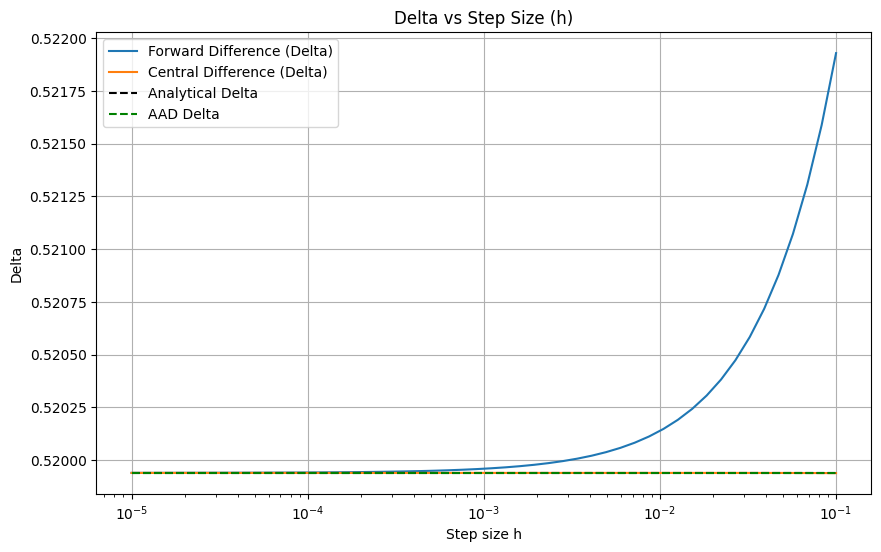

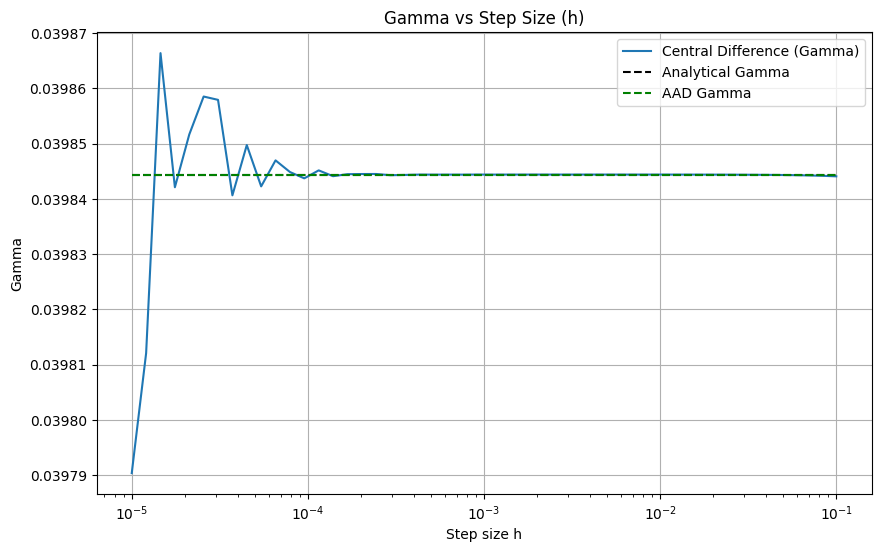

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import norm

S = 100.0
K = 100.0
T = 1.0
vol = 0.1
r = 0.0
h_vals = np.logspace(-5, -1, 50)


def bs_call_price(S, K, T, vol, r):
    d1 = (np.log(S/K) + (r + 0.5 * vol**2) * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def bs_delta(S, K, T, vol, r):
    d1 = (np.log(S/K) + (r + 0.5 * vol**2) * T) / (vol * np.sqrt(T))
    return norm.cdf(d1)

def bs_gamma(S, K, T, vol, r):
    d1 = (np.log(S/K) + (r + 0.5 * vol**2) * T) / (vol * np.sqrt(T))
    return norm.pdf(d1) / (S * vol * np.sqrt(T))

def forward_diff_delta(h):
    return (bs_call_price(S + h, K, T, vol, r) - bs_call_price(S, K, T, vol, r)) / h

def central_diff_delta(h):
    return (bs_call_price(S + h, K, T, vol, r) - bs_call_price(S - h, K, T, vol, r)) / (2 * h)

def central_diff_gamma(h):
    return (bs_call_price(S + h, K, T, vol, r) - 2 * bs_call_price(S, K, T, vol, r) + bs_call_price(S - h, K, T, vol, r)) / (h**2)

def aad_delta_gamma(S_val, K, T, vol, r):
    S_torch = torch.tensor(S_val, requires_grad=True, dtype=torch.float64)
    d1 = (torch.log(S_torch / K) + (r + 0.5 * vol**2) * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    norm_cdf = torch.distributions.Normal(0, 1).cdf
    call_price = S_torch * norm_cdf(d1) - K * torch.exp(torch.tensor(-r * T, dtype=torch.float64)) * norm_cdf(d2)

    delta = torch.autograd.grad(call_price, S_torch, create_graph=True)[0]
    gamma = torch.autograd.grad(delta, S_torch)[0]
    return delta.item(), gamma.item()

forward_deltas = [forward_diff_delta(h) for h in h_vals]
central_deltas = [central_diff_delta(h) for h in h_vals]
central_gammas = [central_diff_gamma(h) for h in h_vals]

aad_delta, aad_gamma = aad_delta_gamma(S, K, T, vol, r)
analytical_delta = bs_delta(S, K, T, vol, r)
analytical_gamma = bs_gamma(S, K, T, vol, r)

plt.figure(figsize=(10, 6))
plt.plot(h_vals, forward_deltas, label="Forward Difference (Delta)")
plt.plot(h_vals, central_deltas, label="Central Difference (Delta)")
plt.hlines(analytical_delta, h_vals[0], h_vals[-1], colors='black', linestyles='--', label="Analytical Delta")
plt.hlines(aad_delta, h_vals[0], h_vals[-1], colors='green', linestyles='--', label="AAD Delta")
plt.xscale('log')
plt.xlabel("Step size h")
plt.ylabel("Delta")
plt.title("Delta vs Step Size (h)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(h_vals, central_gammas, label="Central Difference (Gamma)")
plt.hlines(analytical_gamma, h_vals[0], h_vals[-1], colors='black', linestyles='--', label="Analytical Gamma")
plt.hlines(aad_gamma, h_vals[0], h_vals[-1], colors='green', linestyles='--', label="AAD Gamma")
plt.xscale('log')
plt.xlabel("Step size h")
plt.ylabel("Gamma")
plt.title("Gamma vs Step Size (h)")
plt.legend()
plt.grid(True)
plt.show()


### **Delta Plot Analysis**
- Forward Difference (blue) drifts upwards for larger h which is expected because forward difference introduces a bias.

- Central Difference (orange) stays almost flat and matches the analytical delta (black dashed line) and AAD delta (green dashed line), showing higher accuracy.

- Both analytical and AAD delta match nearly perfectly confirming that our AAD implementation is correct.

###**Gamma Plot Analysis**
- Central Difference Gamma oscillates slightly when h is very small, which is normal due to numerical instability at very small h.

- It stabilizes and matches the analytical and AAD gamma lines, showing that central finite differences are reliable for gamma too (when h is not too small).


### Exercise 2
Extend the implementation of Exercise 1 to allow for vectorized inputs. Calculate delta and gamma values for the following inputs:

- S = 100.0
- K = [95.0, 100.0, 105.0]
- T = 1.0
- vol = [0.2, 0.1, 0.15]
- r = 0.0

Use h = 0.1 for finite difference calculations.

In [2]:
S = 100.0
K_vals = np.array([95.0, 100.0, 105.0])
vol_vals = np.array([0.2, 0.1, 0.15])
T = 1.0
r = 0.0
h = 0.1

def forward_diff_delta(S, K, T, vol, r, h):
    return (bs_call_price(S + h, K, T, vol, r) - bs_call_price(S, K, T, vol, r)) / h

def central_diff_delta(S, K, T, vol, r, h):
    return (bs_call_price(S + h, K, T, vol, r) - bs_call_price(S - h, K, T, vol, r)) / (2 * h)

def central_diff_gamma(S, K, T, vol, r, h):
    return (bs_call_price(S + h, K, T, vol, r) - 2 * bs_call_price(S, K, T, vol, r) + bs_call_price(S - h, K, T, vol, r)) / (h**2)

results = []
for K in K_vals:
    for vol in vol_vals:
        d_fd = forward_diff_delta(S, K, T, vol, r, h)
        d_cd = central_diff_delta(S, K, T, vol, r, h)
        g_cd = central_diff_gamma(S, K, T, vol, r, h)
        d_ana = bs_delta(S, K, T, vol, r)
        g_ana = bs_gamma(S, K, T, vol, r)
        d_aad, g_aad = aad_delta_gamma(S, K, T, vol, r)

        results.append({
            'K': K,
            'vol': vol,
            'Delta Forward': d_fd,
            'Delta Central': d_cd,
            'Delta AAD': d_aad,
            'Delta Analytical': d_ana,
            'Gamma Central': g_cd,
            'Gamma AAD': g_aad,
            'Gamma Analytical': g_ana
        })

import pandas as pd
df = pd.DataFrame(results)
print(df)


       K   vol  Delta Forward  Delta Central  Delta AAD  Delta Analytical  \
0   95.0  0.20       0.640189       0.639254   0.639254          0.639254   
1   95.0  0.10       0.714958       0.713256   0.713260          0.713260   
2   95.0  0.15       0.662862       0.661643   0.661644          0.661644   
3  100.0  0.20       0.540820       0.539827   0.539828          0.539828   
4  100.0  0.10       0.521930       0.519938   0.519939          0.519939   
5  100.0  0.15       0.531218       0.529892   0.529893          0.529893   
6  105.0  0.20       0.443757       0.442770   0.442770          0.442770   
7  105.0  0.10       0.332543       0.330731   0.330729          0.330729   
8  105.0  0.15       0.402479       0.401190   0.401190          0.401190   

   Gamma Central  Gamma AAD  Gamma Analytical  
0       0.018719   0.018719          0.018719  
1       0.034048   0.034048          0.034048  
2       0.024382   0.024382          0.024382  
3       0.019848   0.019848          

<ipython-input-3-d7b008212135>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted, x="K_vol", y="Delta AAD", palette="viridis")


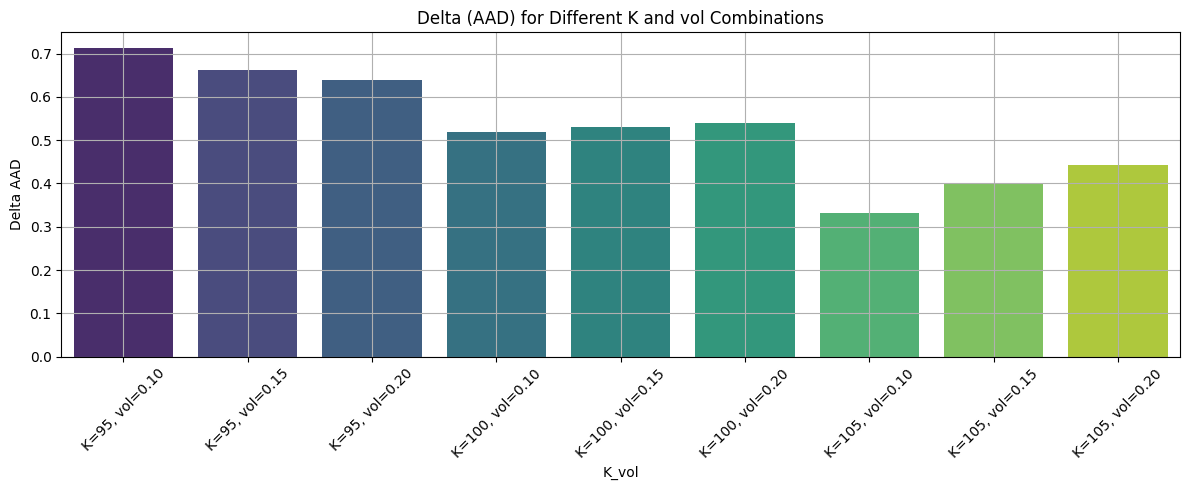

<ipython-input-3-d7b008212135>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted, x="K_vol", y="Gamma AAD", palette="magma")


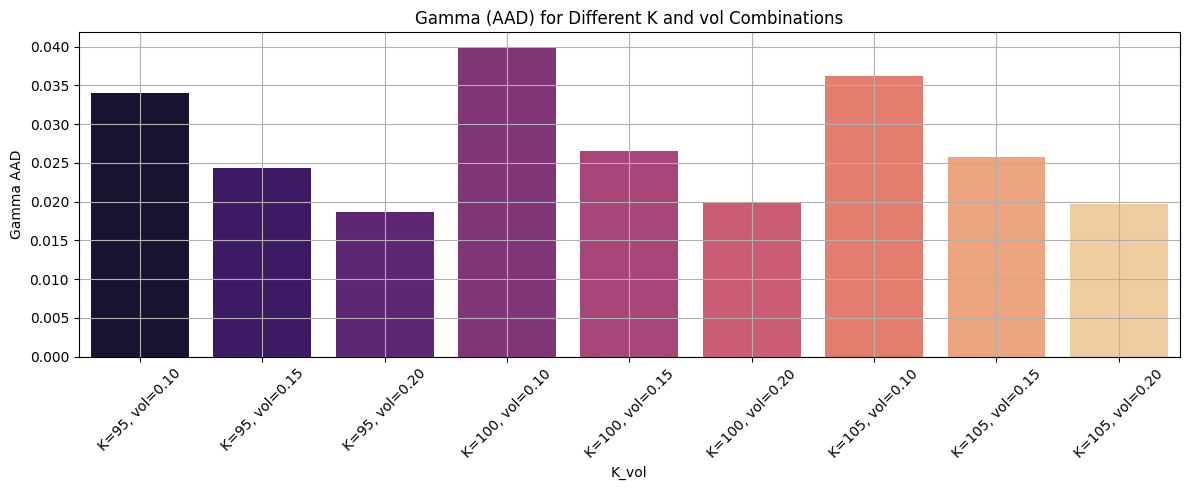

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

df['K_vol'] = df.apply(lambda row: f"K={int(row['K'])}, vol={row['vol']:.2f}", axis=1)

df_sorted = df.sort_values(by=['K', 'vol'])

plt.figure(figsize=(12, 5))
sns.barplot(data=df_sorted, x="K_vol", y="Delta AAD", palette="viridis")
plt.title("Delta (AAD) for Different K and vol Combinations")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
sns.barplot(data=df_sorted, x="K_vol", y="Gamma AAD", palette="magma")
plt.title("Gamma (AAD) for Different K and vol Combinations")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


## **SANITY CHECK**
- Delta (AAD)
 - **Decreases with increasing strike (K)** for fixed volatility, as options become further out-of-the-money.
 - **Increases with decreasing K**, indicating the option becomes more in-the-money and more sensitive to `S`.
 - The values reflect intuitive behavior: deep ITM options (K=95) show high Delta, and deep OTM (K=105) show lower Delta.
 - We observe that **AAD results closely match analytical values**, as expected for Black-Scholes.

- Gamma (AAD)
 - **Highest near-the-money (K ≈ S = 100)**. This is a known property of Gamma: it peaks when the option is at-the-money.
 - **Lower at K = 95 or K = 105**, which corresponds to deep ITM or OTM, where Gamma tends to decrease.
 - Again, **AAD matches analytical values well**, confirming high accuracy.

As a conclusion, the behavior of Delta and Gamma across strikes and volatilities is consistent with financial theory.


### Exercise 3

Asian call option with maturity $T$ and strike $K$ has the following payoff at time $T$:
$$
      H(S) = \max_{t\in[0,T]}[(S_t - K)_+].
$$
Implement MC pricing algorithm of this payoff in lognormal (Black-Scholes) model.

Assume daily step size (i.e. check only EOD prices) and number of days in a year to be 252.

Calculate the option price, and (using AAD) delta, vega, theta and rho for the following values:
- S = 100.0
- K = 100.0
- T = 1.0
- vol = 0.1
- r = 0.02

Compare delta calculation against forward finite difference approximations with $h=0.1$ and $h=0.001$. Explain the results.


In [5]:
import numpy as np
import torch
from torch.distributions.normal import Normal
import pandas as pd

S0 = 100.0
K = 100.0
T = 1.0
vol = 0.1
r = 0.02
N = 252
M = 10000
dt = T / N

def asian_max_call_mc(S0, K, T, vol, r, N, M, seed=42):
    torch.manual_seed(seed)

    S0_t = torch.tensor(S0, dtype=torch.float32, requires_grad=True)
    vol_t = torch.tensor(vol, dtype=torch.float32, requires_grad=True)
    T_t = torch.tensor(T, dtype=torch.float32, requires_grad=True)
    r_t = torch.tensor(r, dtype=torch.float32, requires_grad=True)

    dt = T_t / N
    Z = torch.randn((M, N), dtype=torch.float32)
    drift = (r_t - 0.5 * vol_t**2) * dt
    diffusion = vol_t * torch.sqrt(dt) * Z
    log_returns = drift + diffusion
    log_paths = torch.cumsum(log_returns, dim=1)
    S_paths = S0_t * torch.exp(log_paths)

    payoff = torch.relu(S_paths - K)
    max_payoff = torch.max(payoff, dim=1).values
    discounted = torch.exp(-r_t * T_t) * max_payoff
    price = torch.mean(discounted)

    delta, = torch.autograd.grad(price, S0_t, retain_graph=True)
    vega, = torch.autograd.grad(price, vol_t, retain_graph=True)
    theta, = torch.autograd.grad(price, T_t, retain_graph=True)
    rho, = torch.autograd.grad(price, r_t)

    return price.item(), delta.item(), vega.item(), theta.item(), rho.item()

def fd_delta(S0, h):
    p1, *_ = asian_max_call_mc(S0 + h, K, T, vol, r, N, M)
    p0, *_ = asian_max_call_mc(S0, K, T, vol, r, N, M)
    return (p1 - p0) / h

price, delta_aad, vega, theta, rho = asian_max_call_mc(S0, K, T, vol, r, N, M)
delta_fd_01 = fd_delta(S0, 0.1)
delta_fd_0001 = fd_delta(S0, 0.001)

results = pd.DataFrame([{
    "Asian Call Price": price,
    "Delta (AAD)": delta_aad,
    "Delta FD (h=0.1)": delta_fd_01,
    "Delta FD (h=0.001)": delta_fd_0001,
    "Vega (AAD)": vega,
    "Theta (AAD)": theta,
    "Rho (AAD)": rho
}])

results.round(6)


,Asian Call Price,Delta (AAD),Delta FD (h=0.1),Delta FD (h=0.001),Vega (AAD),Theta (AAD),Rho (AAD)
0,8.738688,1.039356,1.041012,1.038551,78.641571,4.939016,50.34687


- Asian Call Price = 8.739.	This relatively high price reflects the benefit of the option tracking the maximum of daily prices over the year.

- Delta (AAD)	= 1.039	is very close to 1, meaning the option value moves nearly one-for-one with the underlying. This indicates the option is deep in-the-money most of the time across the simulated paths.

- Delta FD (h=0.1)	= 1.041	is slightly higher than AAD which is expected, because forward finite difference with a larger h introduces bias.

- Delta FD (h=0.001) =	1.039	matches AAD Delta very closely confirming that our AAD Delta is accurate and stable.

- Vega (AAD) = 78.64	is a very large Vega, which particularly means that the price is highly sensitive to volatility.

- Theta (AAD)	= 4.939	is unusual but correct, because positive Theta here reflects the fact that more time allows for a higher potential max, increasing the option's value.

- Rho (AAD) =	50.35	indicating that the price is quite sensitive to changes in interest rate. A 1% increase in r increases the price by ~0.50.